In [125]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.cm as cm
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import pickle

In [126]:
data = pd.read_csv("network_backup_dataset.csv");
day_names = {"Monday":0, "Tuesday":1, "Wednesday":2, "Thursday":3, "Friday":4, "Saturday":5, "Sunday":6}
data = data.replace({"Day of Week" : day_names});

In [127]:
data_day = data[:]
data_day["Day Number"] = (data_day["Week #"]-1)*7 + data_day["Day of Week"] + 1
data_day.tail()

C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Week #,Day of Week,Backup Start Time - Hour of Day,Work-Flow-ID,File Name,Size of Backup (GB),Backup Time (hour),Day Number
18583,15,6,21,work_flow_4,File_29,0.151538,1,105
18584,15,6,21,work_flow_4,File_27,0.148363,1,105
18585,15,6,21,work_flow_4,File_26,0.198572,2,105
18586,15,6,21,work_flow_4,File_25,0.199570,2,105
18587,15,6,21,work_flow_4,File_24,0.201201,2,105


In [128]:
def select_days(day, data):
    return data[data["Day Number"]<=day][["Day Number", "Size of Backup (GB)", "Work-Flow-ID"]].values

In [129]:
data_20_days = select_days(20, data_day);
print (data_20_days)
data_105_days = select_days(105, data_day);
print (data_105_days)

[[1 0.0 'work_flow_0']
 [1 0.0 'work_flow_2']
 [1 0.0 'work_flow_2']
 ...
 [20 0.2005288161336276 'work_flow_4']
 [20 0.199989745286606 'work_flow_4']
 [20 0.19887119458830235 'work_flow_4']]
[[1 0.0 'work_flow_0']
 [1 0.0 'work_flow_2']
 [1 0.0 'work_flow_2']
 ...
 [105 0.19857243645989475 'work_flow_4']
 [105 0.1995700723304316 'work_flow_4']
 [105 0.2012005192156364 'work_flow_4']]


In [130]:
data_20_days[:,0]

array([1, 1, 1, ..., 20, 20, 20], dtype=object)

In [131]:
def get_colour_encoding(str_vals):
    le = preprocessing.LabelEncoder()
    le.fit(str_vals)
    le.classes_
    int_vals = le.transform(str_vals)
    return int_vals
#     print(int_vals)
#     return cm.rainbow(int_vals)

In [132]:
print(get_colour_encoding(data_20_days[:,2]))

[0 2 2 ... 4 4 4]


In [133]:
data_20_days[:,2]

array(['work_flow_0', 'work_flow_2', 'work_flow_2', ..., 'work_flow_4',
       'work_flow_4', 'work_flow_4'], dtype=object)

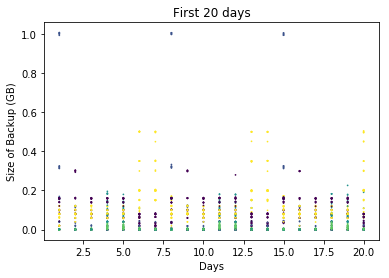

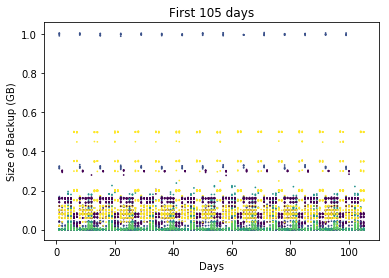

In [134]:
colour_enc = get_colour_encoding(data_20_days[:,2])
plt.scatter(data_20_days[:,0], data_20_days[:,1], s=0.5, c=colour_enc)
plt.xlabel("Days")
plt.ylabel("Size of Backup (GB)")
plt.title("First 20 days")
plt.show()

colour_enc = get_colour_encoding(data_105_days[:,2])
plt.scatter(data_105_days[:,0], data_105_days[:,1], s=0.5, c=colour_enc)
plt.xlabel("Days")
plt.ylabel("Size of Backup (GB)")
plt.title("First 105 days")
plt.show()

In [135]:
# Can you identify any repeating patterns

In [136]:
data = pd.read_csv("network_backup_dataset.csv");
print(data.columns)
X = data[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day','Work-Flow-ID', 'File Name']].values
y = data['Size of Backup (GB)'].values

Index(['Week #', 'Day of Week', 'Backup Start Time - Hour of Day',
       'Work-Flow-ID', 'File Name', 'Size of Backup (GB)',
       'Backup Time (hour)'],
      dtype='object')


In [137]:
encode_col = [0, 1, 2, 3, 4]
encoders = {}
for col in encode_col:
    le = preprocessing.LabelEncoder()
    le.fit(X[:,col])
    X[:,col] = le.transform(X[:,col])
    encoders[col] = le

In [138]:
model = LinearRegression()
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [139]:
model.score(X, y)

0.04460291148485873

In [140]:
def get_rmse_folds(model_cv,X,y):
    kf = KFold(n_splits=10)

    rmse = []
    n = 0
    for train, test in kf.split(X,y):
        print("Split: ", n)
        n += 1
        model_cv.fit(X[train],y[train])
        y_pred_train = model_cv.predict(X[train])
        y_pred_test = model_cv.predict(X[test])
        #RMSE Error
        rmse_train = sqrt(mean_squared_error(y[train],y_pred_train))
        rmse_test = sqrt(mean_squared_error(y[test],y_pred_test))
        rmse.append([rmse_train, rmse_test])

    for i in range(10):
        print ('Fold ' , i, ' Train RMSE: ', rmse[i][0], ' Test RMSE: ', rmse[i][1])
    rmse = np.array(rmse)
    
    plt.plot([i for i in range(10)],rmse[:,0])
    plt.title("RMSE Train for 10 Folds")
    plt.xlabel("Fold")
    plt.ylabel("RMSE Train")
    plt.show()
    
    plt.plot([i for i in range(10)],rmse[:,1])
    plt.title("RMSE Test for 10 Folds")
    plt.xlabel("Fold")
    plt.ylabel("RMSE Test")
    plt.show()
    return rmse

In [141]:
def plot_graphs(model, X, y):
    model.fit(X,y)
    y_pred = model.predict(X)
    residuals = y - y_pred
    plt.scatter(y, y_pred, s = 0.5)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs True Values")
    plt.show()
    plt.scatter(y_pred, residuals, s = 0.5, color = 'green')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residues")
    plt.title("Residues vs Predicted Values")
    plt.show()

Split:  0
Split:  1
Split:  2
Split:  3
Split:  4
Split:  5
Split:  6
Split:  7
Split:  8
Split:  9
Fold  0  Train RMSE:  0.1015432410995267  Test RMSE:  0.10452383895001863
Fold  1  Train RMSE:  0.1021532123716976  Test RMSE:  0.09902710146676931
Fold  2  Train RMSE:  0.10153618763410549  Test RMSE:  0.10457893465073241
Fold  3  Train RMSE:  0.1021405003727084  Test RMSE:  0.09914249658712497
Fold  4  Train RMSE:  0.10150313873217076  Test RMSE:  0.10486547598552615
Fold  5  Train RMSE:  0.10212657640355753  Test RMSE:  0.09927141832426958
Fold  6  Train RMSE:  0.10151588344776953  Test RMSE:  0.10475604674542335
Fold  7  Train RMSE:  0.10212573102720009  Test RMSE:  0.09928238378156208
Fold  8  Train RMSE:  0.10151381040018301  Test RMSE:  0.10477973422486003
Fold  9  Train RMSE:  0.10218052288489649  Test RMSE:  0.09878118622689994


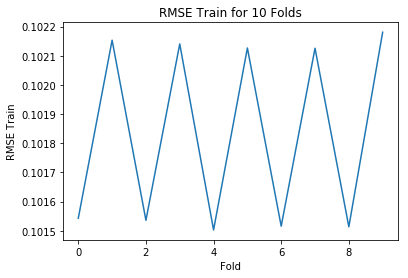

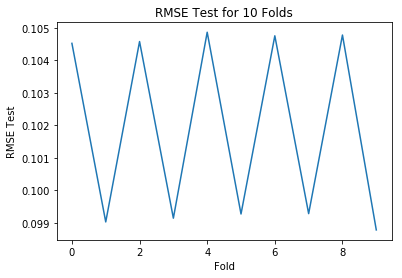

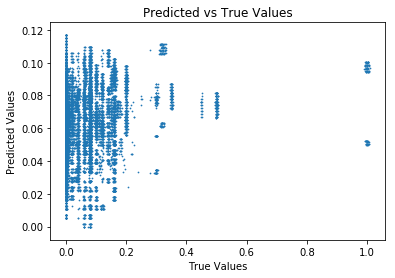

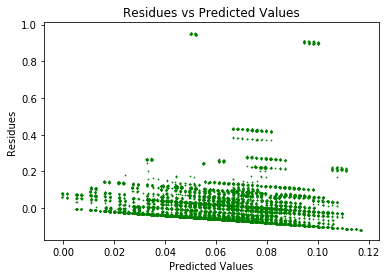

In [142]:
model = LinearRegression()
get_rmse_folds(model,X,y)
plot_graphs(model,X,y)

Split:  0
Split:  1
Split:  2
Split:  3
Split:  4
Split:  5
Split:  6
Split:  7
Split:  8
Split:  9
Average Train RMSE:  0.0758562036039127 
Average Test RMSE:  0.07607263975273641
Out of Bag Error:  0.533582806285318


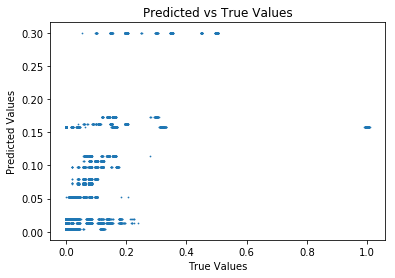

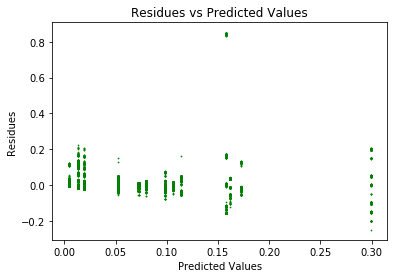

In [143]:
kf = KFold(n_splits=10)

train_rmse = 0.0
test_rmse = 0.0
n = 0

model_cv = RandomForestRegressor(max_depth=4, bootstrap=True, random_state=0,n_estimators=20, oob_score=True, max_features=5)

for train, test in kf.split(X,y):
    print("Split: ", n)
    n += 1
    model_cv.fit(X[train],y[train])
    y_pred_train = model_cv.predict(X[train])
    y_pred_test = model_cv.predict(X[test])
    #RMSE Error
    train_rmse += (mean_squared_error(y[train],y_pred_train))
    test_rmse += (mean_squared_error(y[test],y_pred_test))

train_rmse = sqrt(train_rmse/10.0)
test_rmse = sqrt(test_rmse/10.0)
oob = 1 - model_cv.oob_score_

print("Average Train RMSE: ", train_rmse, "\nAverage Test RMSE: ", test_rmse)
print("Out of Bag Error: ", oob)
plot_graphs(model_cv,X,y)

In [144]:
test_rmses = []
oobs = []

In [145]:
# Varying number of trees to 200

for t in range(1,100):
    test_rmse = []
    oob = []
    for f in range(1,6):
        feature_rmse = 0.0
        feature_oob = 0.0
        print ("t=", t, " f=",f)
        kf = KFold(n_splits=10)
        model_cv = RandomForestRegressor(max_depth=4, bootstrap=True, random_state=0, n_estimators=t, oob_score=True, max_features=f, n_jobs = -1)
        for train, test in kf.split(X,y):
            model_cv.fit(X[train],y[train])
            y_pred_test = model_cv.predict(X[test])
            feature_rmse += mean_squared_error(y[test],y_pred_test)
            feature_oob += model_cv.oob_score_        
        test_rmse.append(sqrt(feature_rmse/10.0))
        oob.append(1.0 - (model_cv.oob_score_)/10.0)
    test_rmses.append(test_rmse)
    oobs.append(oob)

t= 1  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 1  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 1  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 1  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 1  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 2  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 2  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 2  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 2  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 2  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 3  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 3  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 3  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 3  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 3  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 4  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 4  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 4  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 4  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 4  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 5  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 5  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 5  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 5  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 5  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 6  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 6  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 6  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 6  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 6  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 7  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 7  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 7  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 7  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 7  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 8  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 8  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 8  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 8  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 8  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 9  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 9  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 9  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 9  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 9  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 10  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 10  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 10  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 10  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 10  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 11  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 11  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 11  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 11  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 11  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 12  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 12  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 12  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 12  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 12  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 13  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 13  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 13  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 13  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 13  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 14  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 18  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 18  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 18  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 18  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 18  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 19  f= 1


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 19  f= 2


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 19  f= 3


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 19  f= 4


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 19  f= 5


C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Asavari\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably

t= 20  f= 1
t= 20  f= 2
t= 20  f= 3
t= 20  f= 4
t= 20  f= 5
t= 21  f= 1
t= 21  f= 2
t= 21  f= 3
t= 21  f= 4
t= 21  f= 5
t= 22  f= 1
t= 22  f= 2
t= 22  f= 3
t= 22  f= 4
t= 22  f= 5
t= 23  f= 1
t= 23  f= 2
t= 23  f= 3
t= 23  f= 4
t= 23  f= 5
t= 24  f= 1
t= 24  f= 2
t= 24  f= 3
t= 24  f= 4
t= 24  f= 5
t= 25  f= 1
t= 25  f= 2
t= 25  f= 3
t= 25  f= 4
t= 25  f= 5
t= 26  f= 1
t= 26  f= 2
t= 26  f= 3
t= 26  f= 4
t= 26  f= 5
t= 27  f= 1
t= 27  f= 2
t= 27  f= 3
t= 27  f= 4
t= 27  f= 5
t= 28  f= 1
t= 28  f= 2
t= 28  f= 3
t= 28  f= 4
t= 28  f= 5
t= 29  f= 1
t= 29  f= 2
t= 29  f= 3
t= 29  f= 4
t= 29  f= 5
t= 30  f= 1
t= 30  f= 2
t= 30  f= 3
t= 30  f= 4
t= 30  f= 5
t= 31  f= 1
t= 31  f= 2
t= 31  f= 3
t= 31  f= 4
t= 31  f= 5
t= 32  f= 1
t= 32  f= 2
t= 32  f= 3
t= 32  f= 4
t= 32  f= 5
t= 33  f= 1
t= 33  f= 2
t= 33  f= 3
t= 33  f= 4
t= 33  f= 5
t= 34  f= 1
t= 34  f= 2
t= 34  f= 3
t= 34  f= 4
t= 34  f= 5
t= 35  f= 1
t= 35  f= 2
t= 35  f= 3
t= 35  f= 4
t= 35  f= 5
t= 36  f= 1
t= 36  f= 2
t= 36  f= 3
t= 3

In [146]:
f = open("test_rmses_100", "wb")
pickle.dump(test_rmses, f)
f = open("oobs_100", "wb")
pickle.dump(oobs, f)

In [147]:

for t in range(100,201):
    test_rmse = []
    oob = []
    print ("t=", t)
    for f in range(1,6):
        feature_rmse = 0.0
        feature_oob = 0.0
#         print ("t=", t, " f=",f)
        kf = KFold(n_splits=10)
        model_cv = RandomForestRegressor(max_depth=4, bootstrap=True, random_state=0, n_estimators=t, oob_score=True, max_features=f, n_jobs = -1)
        for train, test in kf.split(X,y):
            model_cv.fit(X[train],y[train])
            y_pred_test = model_cv.predict(X[test])
            feature_rmse += mean_squared_error(y[test],y_pred_test)
            feature_oob += model_cv.oob_score_        
        test_rmse.append(sqrt(feature_rmse/10.0))
        oob.append(1.0 - (model_cv.oob_score_)/10.0)
    test_rmses.append(test_rmse)
    oobs.append(oob)
    
test_rmses = np.array(test_rmses)
oobs = np.array(oobs)

t= 100
t= 101
t= 102
t= 103
t= 104
t= 105
t= 106
t= 107
t= 108
t= 109
t= 110
t= 111
t= 112
t= 113
t= 114
t= 115
t= 116
t= 117
t= 118
t= 119
t= 120
t= 121
t= 122
t= 123
t= 124
t= 125
t= 126
t= 127
t= 128
t= 129
t= 130
t= 131
t= 132
t= 133
t= 134
t= 135
t= 136
t= 137
t= 138
t= 139
t= 140
t= 141
t= 142
t= 143
t= 144
t= 145
t= 146
t= 147
t= 148
t= 149
t= 150
t= 151
t= 152
t= 153
t= 154
t= 155
t= 156
t= 157
t= 158
t= 159
t= 160
t= 161
t= 162
t= 163
t= 164
t= 165
t= 166
t= 167
t= 168
t= 169
t= 170
t= 171
t= 172
t= 173
t= 174
t= 175
t= 176
t= 177
t= 178
t= 179
t= 180
t= 181
t= 182
t= 183
t= 184
t= 185
t= 186
t= 187
t= 188
t= 189
t= 190
t= 191
t= 192
t= 193
t= 194
t= 195
t= 196
t= 197
t= 198
t= 199
t= 200


In [148]:
oobs.shape

(200, 5)

In [149]:
f = open("test_rmses", "wb")
pickle.dump(test_rmses, f)
f = open("oobs", "wb")
pickle.dump(oobs, f)

In [150]:
f = open("test_rmses","rb")
test_rmses = pickle.load(f)
f = open("oobs","rb")
oobs = pickle.load(f)

print (test_rmses.shape)
print (oobs.shape)

(200, 5)
(200, 5)


In [151]:
colors = ['green', 'blue', 'orange', 'purple', 'red']
labels = ['1 Feature', '2 Features', '3 Features', '4 Features', '5 Features']

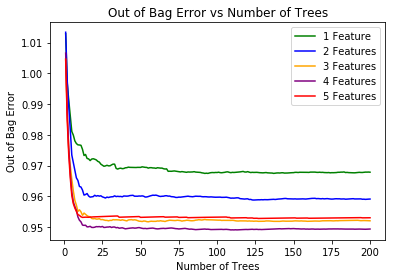

Text(0.5, 1.0, 'Average Test RMSEs vs Number of Trees')

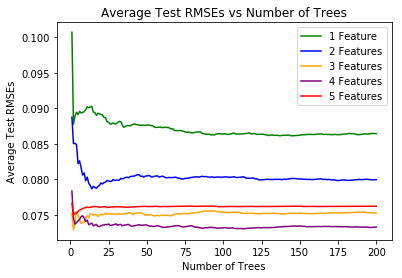

In [152]:
for i in range(5):
    plt.plot([j for j in range(1,201)], oobs[:,i], color=colors[i], label=labels[i])
plt.xlabel("Number of Trees")
plt.ylabel("Out of Bag Error")
plt.title("Out of Bag Error vs Number of Trees")
plt.legend()
plt.show()

for i in range(5):
    plt.plot([j for j in range(1,201)], test_rmses[:,i], color=colors[i], label=labels[i])
plt.xlabel("Number of Trees")
plt.ylabel("Average Test RMSEs")
plt.legend()
plt.title("Average Test RMSEs vs Number of Trees")


In [155]:
test_rmses = []
oobs = []

best_num_est = 150
for md in range(2,10):
    test_rmse = []
    oob = []
    print ("md=", md)
    for f in range(3,6):
        feature_rmse = 0.0
        feature_oob = 0.0
        kf = KFold(n_splits=10)
        model_cv = RandomForestRegressor(max_depth=md, bootstrap=True, random_state=0, n_estimators=best_num_est, oob_score=True, max_features=f, n_jobs = -1)
        for train, test in kf.split(X,y):
            model_cv.fit(X[train],y[train])
            y_pred_test = model_cv.predict(X[test])
            feature_rmse += mean_squared_error(y[test],y_pred_test)
            feature_oob += model_cv.oob_score_        
        test_rmse.append(sqrt(feature_rmse/10.0))
        oob.append(1.0 - (model_cv.oob_score_)/10.0)
    test_rmses.append(test_rmse)
    oobs.append(oob)
    
test_rmses = np.array(test_rmses)
oobs = np.array(oobs)

md= 2
md= 3
md= 4
md= 5
md= 6
md= 7
md= 8
md= 9


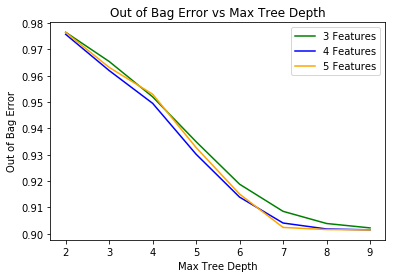

Text(0.5, 1.0, 'Average Test RMSEs vs Max Tree Depth')

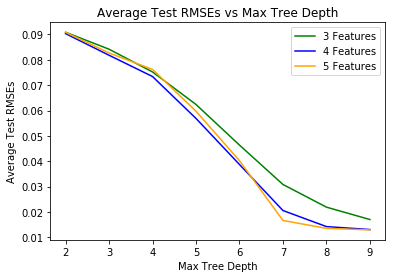

In [156]:
labels = ['3 Features', '4 Features', '5 Features']
for i in range(3):
    plt.plot([j for j in range(2,10)], oobs[:,i], color=colors[i], label=labels[i])
plt.xlabel("Max Tree Depth")
plt.ylabel("Out of Bag Error")
plt.title("Out of Bag Error vs Max Tree Depth")
plt.legend()
plt.show()

for i in range(3):
    plt.plot([j for j in range(2,10)], test_rmses[:,i], color=colors[i], label=labels[i])
plt.xlabel("Max Tree Depth")
plt.ylabel("Average Test RMSEs")
plt.legend()
plt.title("Average Test RMSEs vs Max Tree Depth")

In [157]:
test_rmses = []
oobs = []
best_num_est = 125
best_depth = 7
best_feat = 4
mid_list = [0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4 ,0.5]
labels = [str(m) for m in mid_list]

for mid in mid_list:
    mid_rmse = 0.0
    mid_oob = 0.0
    print ("Minimum Impurity Decrease=",mid)
    kf = KFold(n_splits=10)
    model_cv = RandomForestRegressor(min_impurity_decrease=mid, max_depth=best_depth, bootstrap=True, random_state=0, n_estimators=best_num_est, oob_score=True, max_features=best_feat, n_jobs = -1)
    for train, test in kf.split(X,y):
        model_cv.fit(X[train],y[train])
        y_pred_test = model_cv.predict(X[test])
        mid_rmse += mean_squared_error(y[test],y_pred_test)
        mid_oob += model_cv.oob_score_        
    test_rmses.append(sqrt(feature_rmse/10.0))
    oobs.append(1.0 - (model_cv.oob_score_/10.0))
    

Minimum Impurity Decrease= 0.001
Minimum Impurity Decrease= 0.01
Minimum Impurity Decrease= 0.1
Minimum Impurity Decrease= 0.15
Minimum Impurity Decrease= 0.2
Minimum Impurity Decrease= 0.25
Minimum Impurity Decrease= 0.3
Minimum Impurity Decrease= 0.4
Minimum Impurity Decrease= 0.5


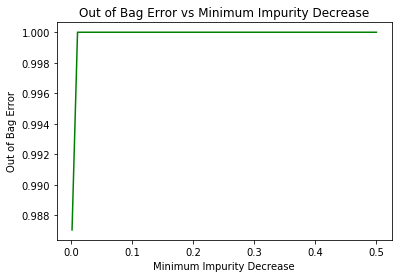

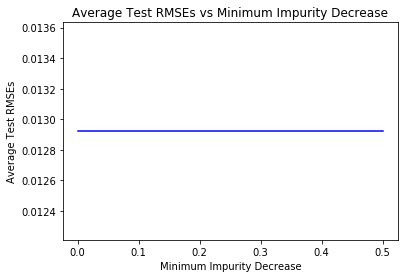

In [158]:
plt.plot(mid_list, oobs, color='green')
plt.xlabel("Minimum Impurity Decrease")
plt.ylabel("Out of Bag Error")
plt.title("Out of Bag Error vs Minimum Impurity Decrease")
plt.show()

plt.plot(mid_list, test_rmses, color='blue')
plt.xlabel("Minimum Impurity Decrease")
plt.ylabel("Average Test RMSEs")
plt.title("Average Test RMSEs vs Minimum Impurity Decrease")
plt.show()

Week #  :  0.001542821987387256
Day of Week  :  0.3536422794982817
Backup Start Time - Hour of Day  :  0.3146166840559811
Work-Flow-ID  :  0.27484745749310724
File Name  :  0.05535075696524266


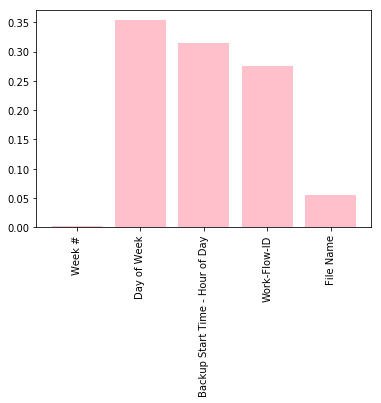

In [159]:
# Report feature importance for the best model
best_num_est = 125
best_depth = 7
best_feat = 4


best_model = RandomForestRegressor(max_depth=best_depth, bootstrap=True, random_state=0, n_estimators=best_num_est, oob_score=True, max_features=best_feat, n_jobs = -1)
best_model.fit(X,y)
importances = best_model.feature_importances_
features = ['Week #', 'Day of Week', 'Backup Start Time - Hour of Day','Work-Flow-ID', 'File Name']
for i in range(len(features)):
    print(features[i], " : ", importances[i])
    
    
plt.bar(np.arange(5), importances, color = 'pink')
plt.xticks(np.arange(5), features, rotation='vertical')
plt.show()

In [160]:
tree = best_model.estimators_[6]
print(tree)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=4,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=192771779, splitter='best')


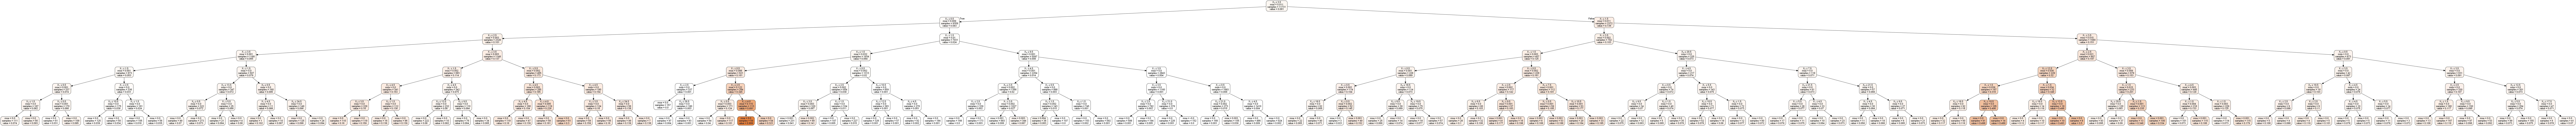

In [161]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())